In [1]:
setwd('/Users/alexis/IEHS Dropbox/Rager Lab/Alexis_Payton/4_Compartment_Analysis_2021/Expt1.1_Cluster Distribution Analyses/Input')
Output = ('/Users/alexis/IEHS Dropbox/Rager Lab/Alexis_Payton/4_Compartment_Analysis_2021/Expt1.1_Cluster Distribution Analyses/Output')
cur_date = "041721"

library(readxl)
library(data.table)
library(factoextra)
library(dplyr)
library(tidyverse)
library(gridExtra)
library(cluster)
library(vegan)
library(fpc)
library(ggdendro)
library(NbClust)
library(ggrepel)


#reading in files
cytokines <- data.frame(read_excel("CytokineData_032521.xlsx", sheet = 2))
subjects = data.frame(read_excel("SubjectInfo_032521.xlsx", sheet = 2))

Loading required package: ggplot2

Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ tibble  3.0.6     ✔ purrr   0.3.4
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::transpose() masks data.table::transpose()


Attaching package: ‘gridExtra’


The f

This is an analysis to determine how baseline cytokines cluster (using k means) and to get their corresponding eigencytokines by compartment. Want to get clusters that are similar to those in previous dataset. 

In [14]:
for (i in seq_len(cytokines$Conc_pslog2)){
    if (cytokines$Conc_pslog2[i] == 0){
        cytokines$Conc_pslog2[i] = NULL
    }
}

Warning message in seq_len(cytokines$Conc_pslog2):
“first element used of 'length.out' argument”


In [2]:
#either pivot wider or dcast works
#cytokines %>%
    #filter(Group == 'NS') %>%
    #select(-Compartment, -SubjectNo, -Conc_pslog2, -Group) %>%
    #pivot_wider(names_from = Protein, values_from = Conc_pslog2)

new_dataset_only_cytokines = c("GMCSF", "IL12p40", "IL15", "IL16", "IL17","IL1a", "IL2", "IL5", "IL7", "MCP4", "MDC","TNFb", "VEGF")
`%notin%` <- Negate(`%in%`)
#changing format of df
cytokines = cytokines %>% 
    #only want non-smokers for baseline analysis & cytokines that were in the previous dataset
    filter(Group == 'NS', Protein %notin% new_dataset_only_cytokines) #%>% 
    #background filter eliminating any cytokines that are not expressed
    #mutate(Conc_pslog2 = ifelse(Conc_pslog2 == 0, NULL, Conc_pslog2))
for (i in seq_len(cytokines$Conc_pslog2)){
    if (cytokines$Conc_pslog2[i] == 0){
        cytokines$Conc_pslog2[i] = NULL
    }
}

cytokines = reshape2::dcast(cytokines, SubjectID ~ Protein, value.var = "Conc_pslog2") %>% 
    column_to_rownames("SubjectID") 

Warning message in seq_len(cytokines$Conc_pslog2):
“first element used of 'length.out' argument”


ERROR: Error in cytokines$Conc_pslog2[i] <- NULL: replacement has length zero


# Baseline Clusters

First, we can estimate the optimal number of clusters, as described in:
- https://afit-r.github.io/kmeans_clustering
- https://www.datanovia.com/en/lessons/k-means-clustering-in-r-algorith-and-practical-examples/
- https://www.datanovia.com/en/lessons/determining-the-optimal-number-of-clusters-3-must-know-methods/

> - Compute k-means clustering using different values of clusters k
> - Next, the wss (within sum of square) is drawn according to the number of clusters
> - The location of a bend (knee) in the plot is generally considered as an indicator of the appropriate number of clusters.
> - The R function fviz_nbclust() [in factoextra package] provides a convenient solution to estimate the optimal number of clusters.

In [ ]:
fviz_nbclust(cytokines, kmeans, method = "wss") +
# The generated plot represents the variance within the clusters. It decreases as k increases, but it can be seen a bend (or “elbow”) at k = 4
  labs(subtitle = "Elbow method") # suggests 4
fviz_nbclust(cytokines, kmeans, method = "silhouette") + 
  labs(subtitle="Silhouette method") # suggests 3 

Run the cluster code using the identified number of clusters for subjects first.

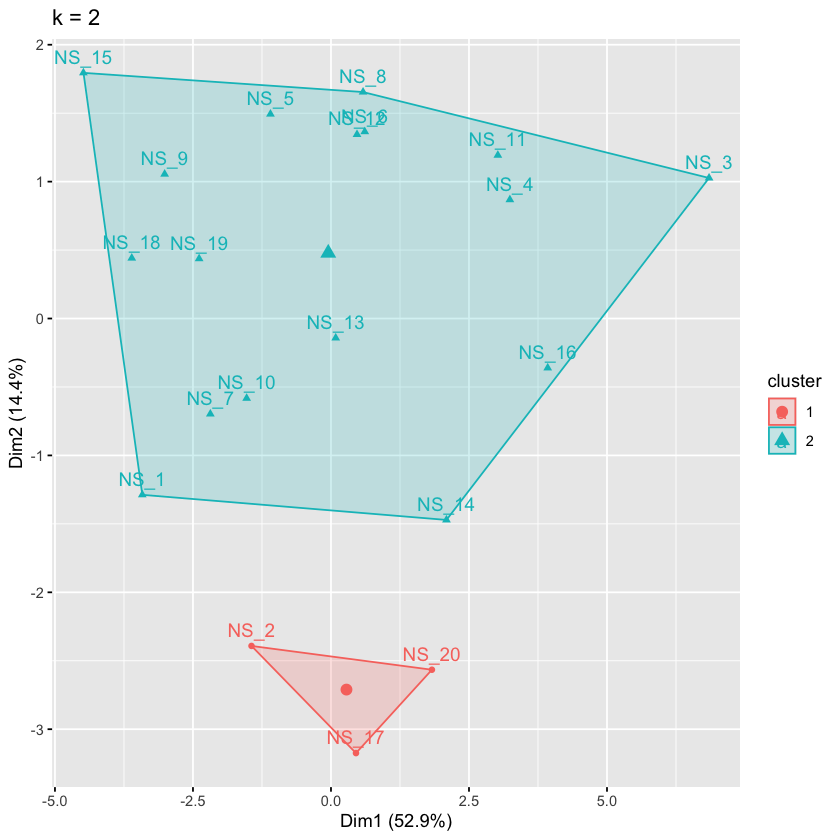

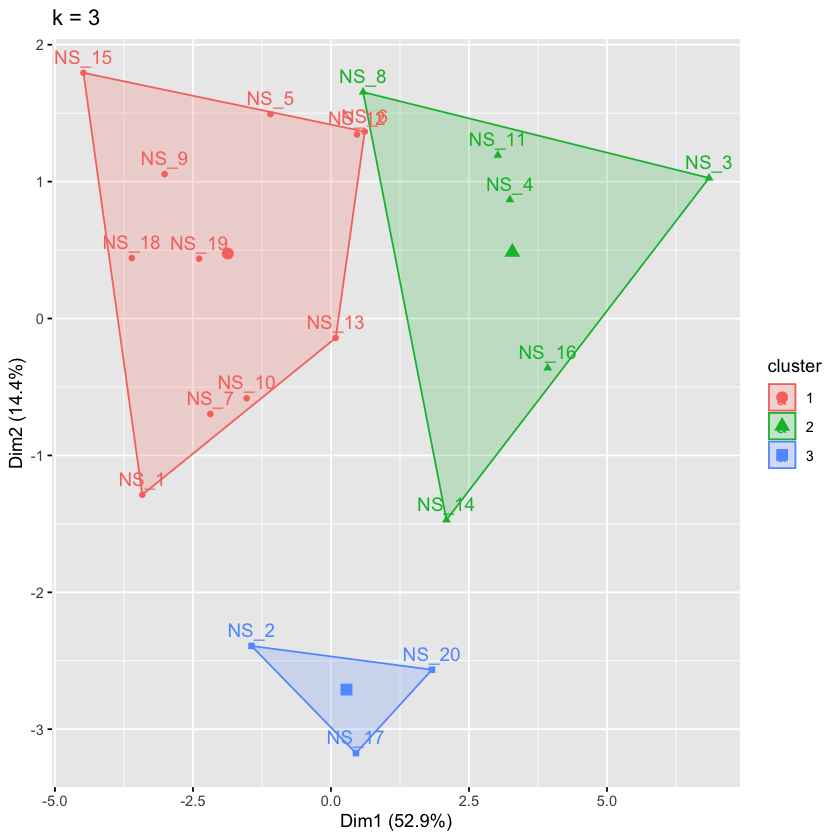

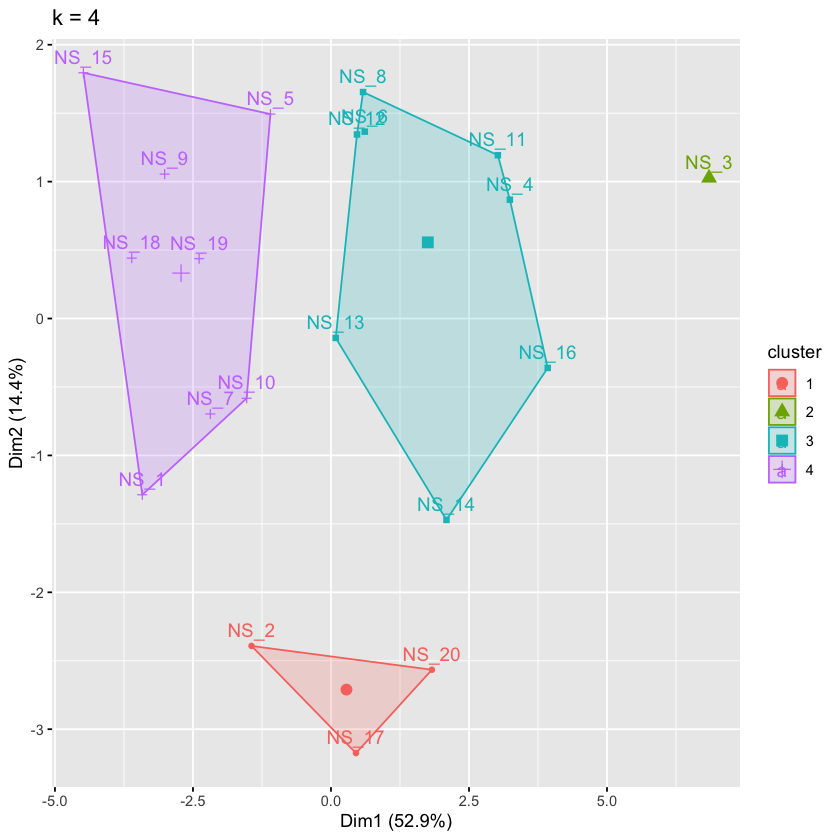

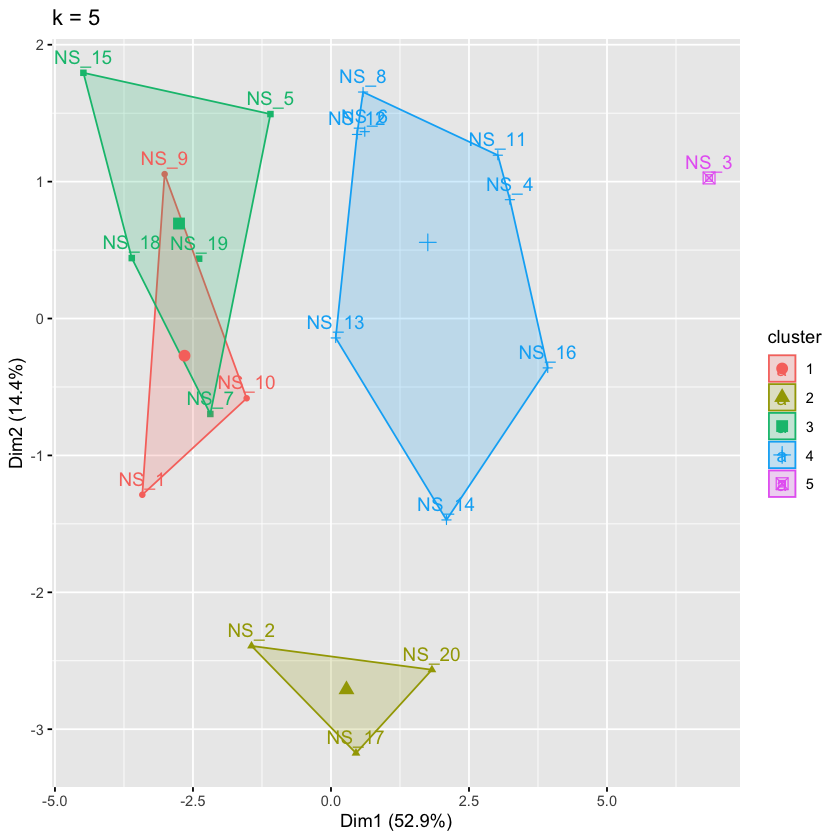

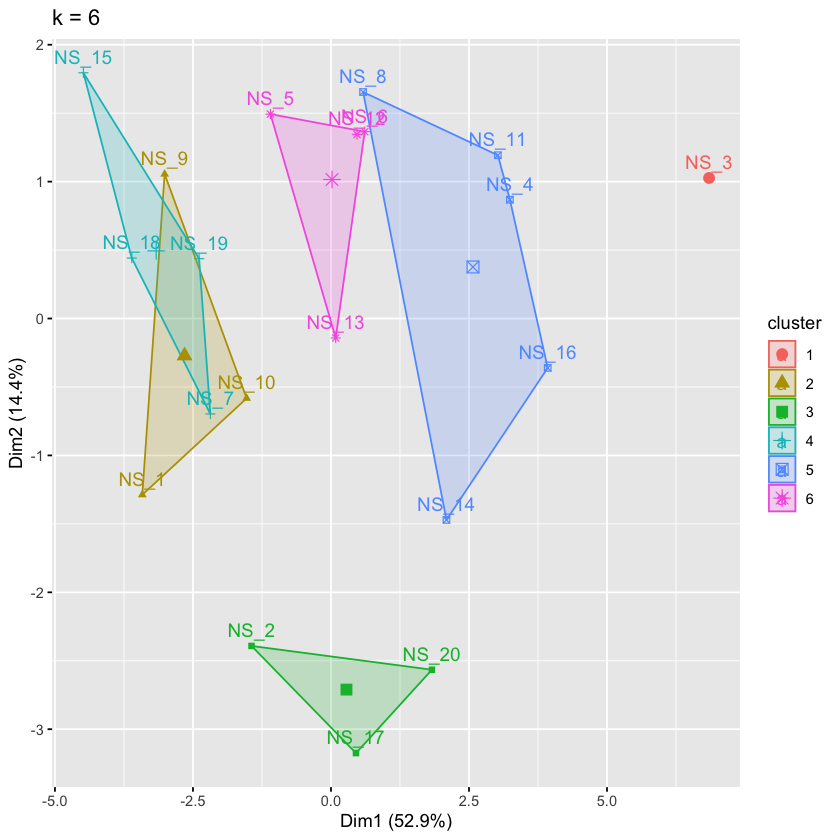

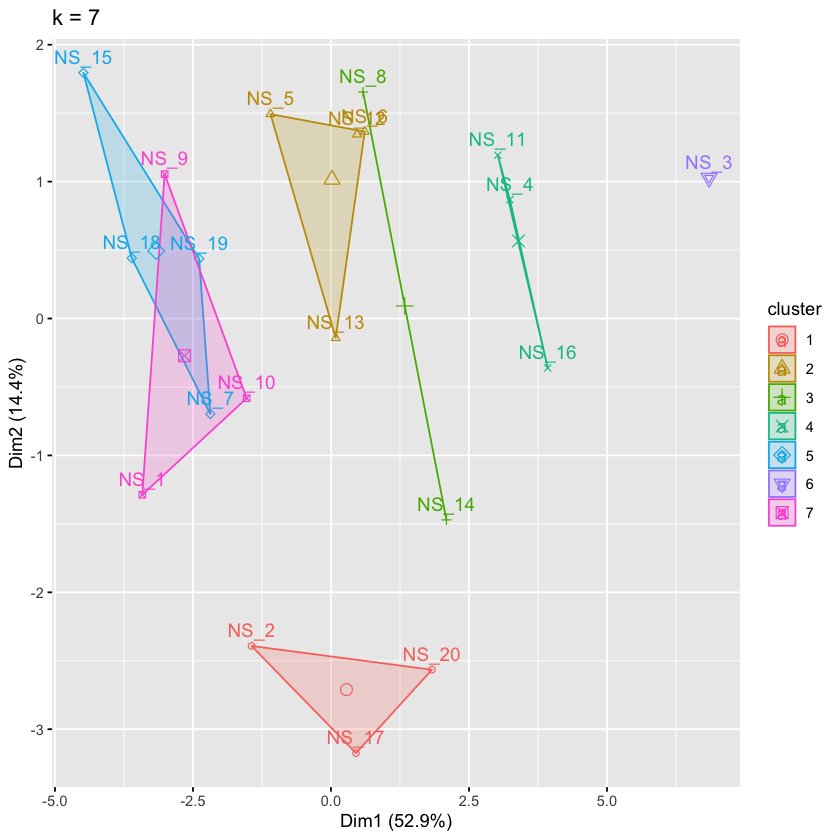

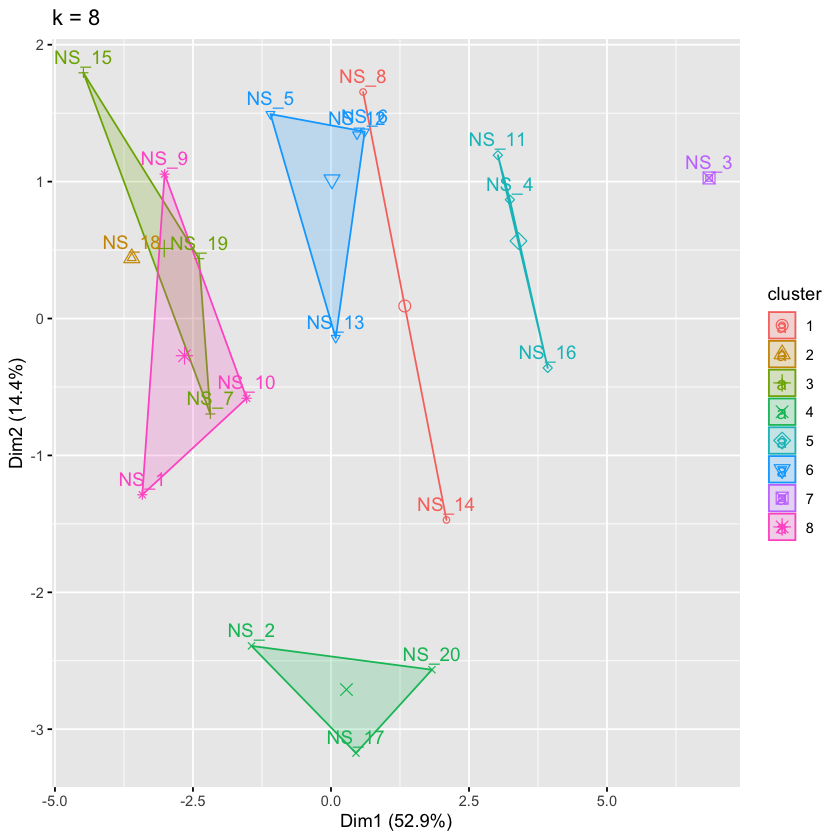

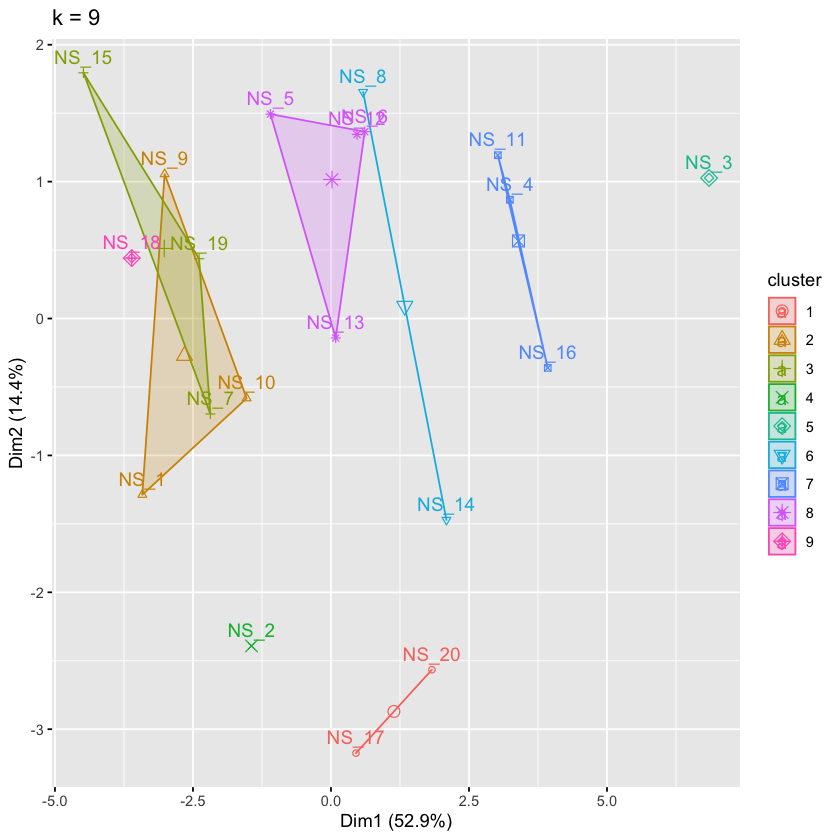

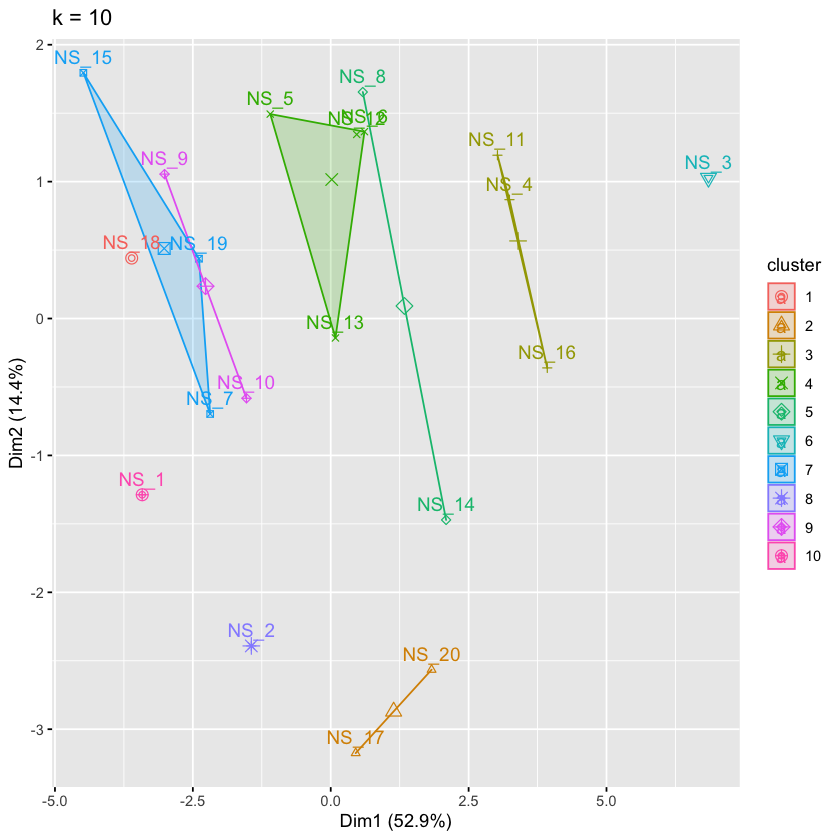

In [4]:
# Since the initial cluster assignments are random, we need to set the seed to ensure reproducibility
set.seed(151)

# Running the basic cluster analysis code
# kmeans(x, centers, iter.max = 10, nstart = 1)
# where:
#   x: numeric matrix, numeric data frame or a numeric vector
#   centers: Possible values are the number of clusters (k) or a set of initial (distinct) cluster centers. If a number, a random set of (distinct) rows in x is chosen as the initial centers.
#   iter.max: The maximum number of iterations allowed. Default value is 10.
#   nstart: The number of random starting partitions when centers is a number.
#   This means that R will try nstart different random starting assignments and then select the best results corresponding to the one with the lowest within cluster variation. The default value of nstart in R is one. But, it’s strongly recommended to compute k-means clustering with a large value of nstart such as 25 or 50, in order to have a more stable result.

# Testing different numbers of clusters (k)

cluster_plots = list()
for (i in 2:10){
    cytokines_Cluster_k <- kmeans(cytokines, centers = i, nstart = 25)
    cluster_plots[[i]] <- fviz_cluster(cytokines_Cluster_k, data = cytokines) + ggtitle(paste0("k = ",i))
    print(cluster_plots[[i]])
}
#do.call("grid.arrange", c(cluster_plots, nrow = 3))
#grid.arrange(cluster_plots[[1]],cluster_plots[[2]], cluster_plots[[3]], nrow = 3)

Estimating optimal number of clusters for cytokines.

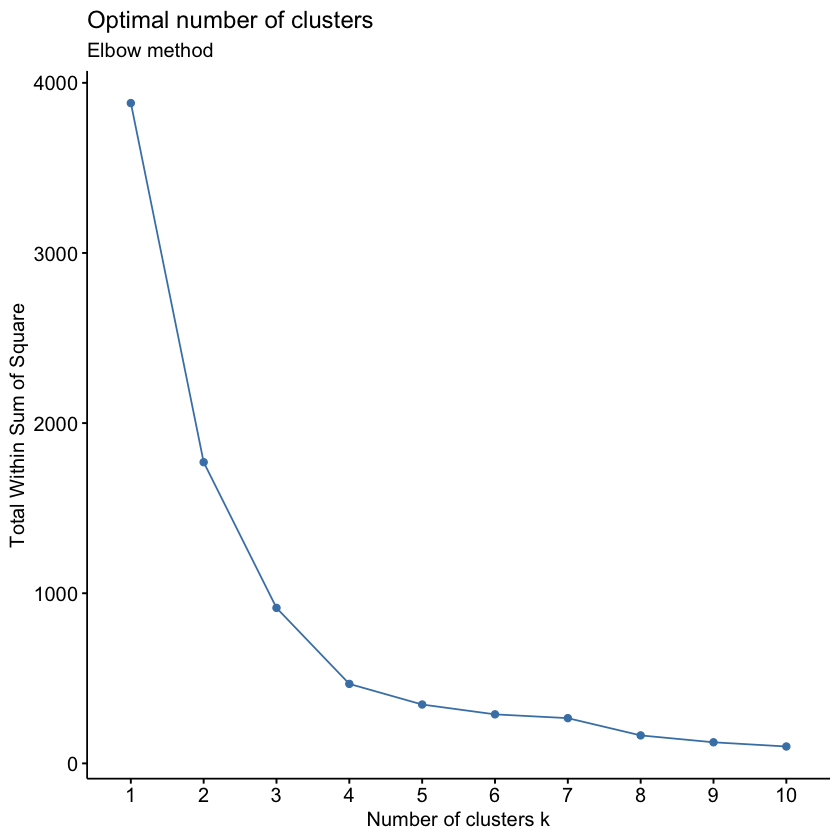

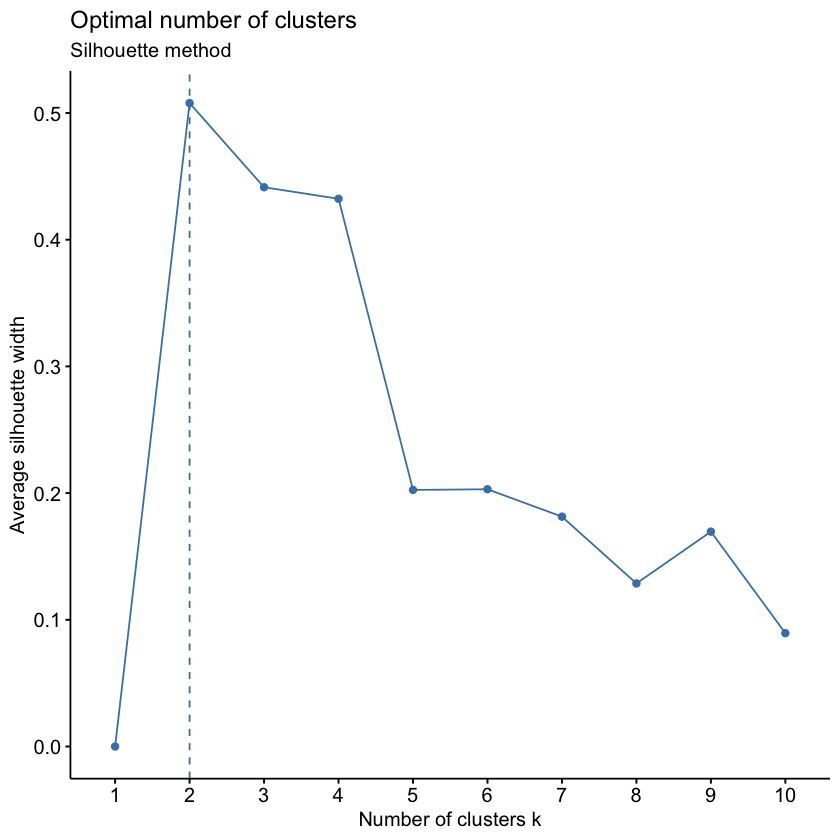

In [5]:
tcytokines = data.frame(t(cytokines))
fviz_nbclust(tcytokines, kmeans, method = "wss") +
  labs(subtitle = "Elbow method") # suggests 6
fviz_nbclust(tcytokines, kmeans, method = "silhouette") + 
  labs(subtitle="Silhouette method") # suggests 6

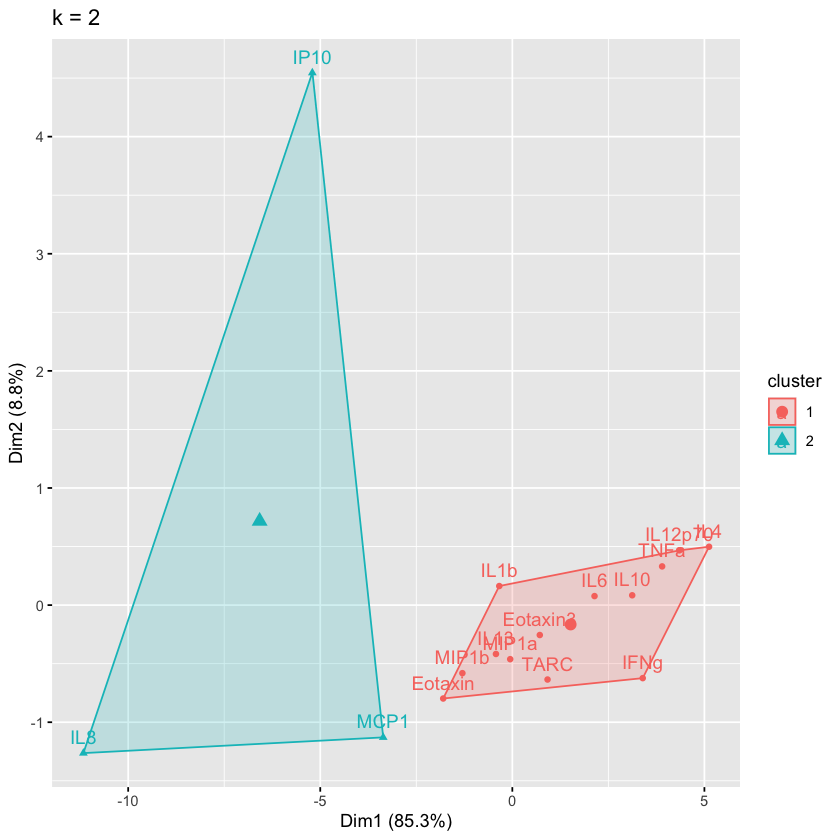

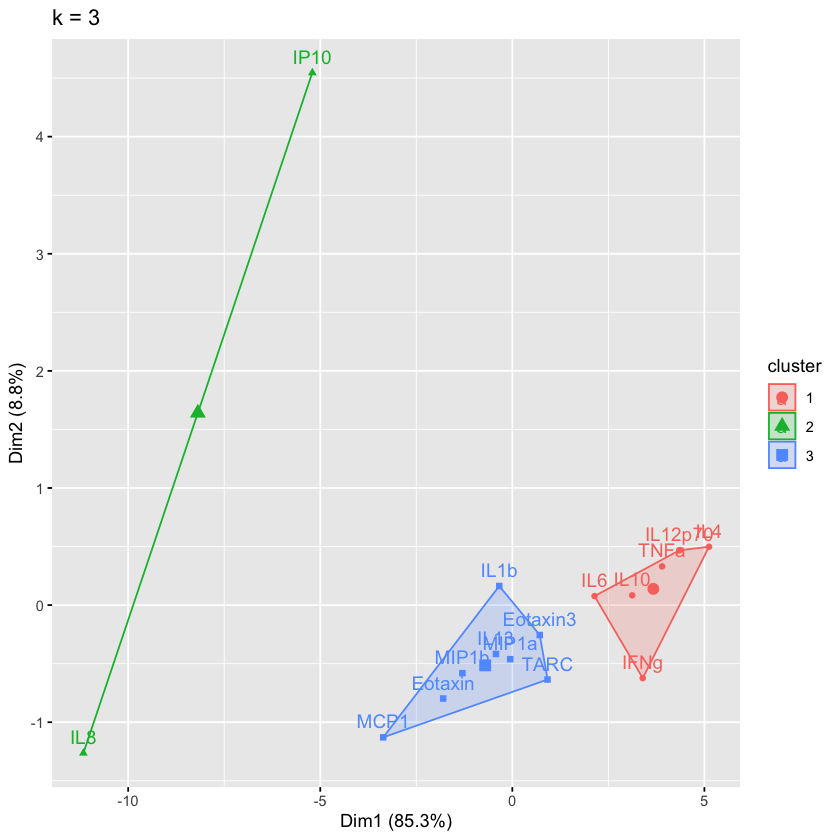

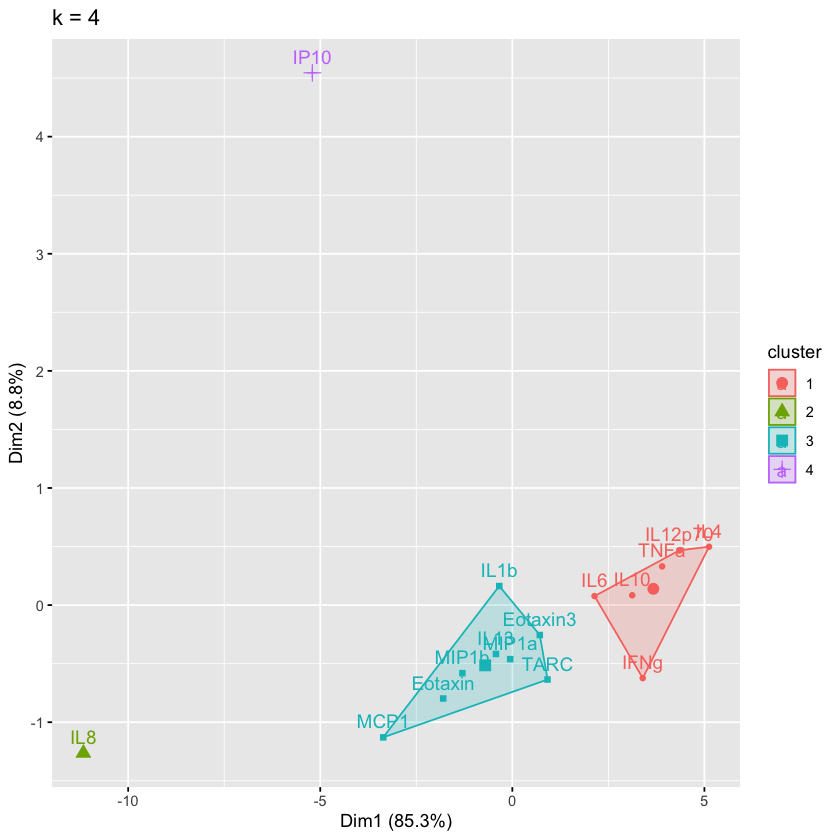

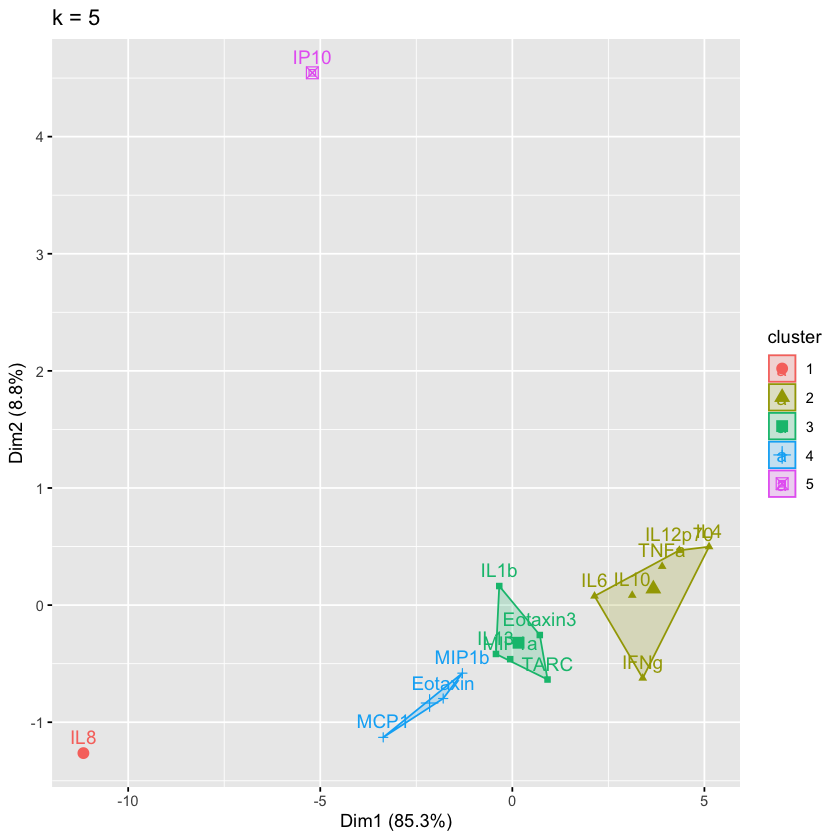

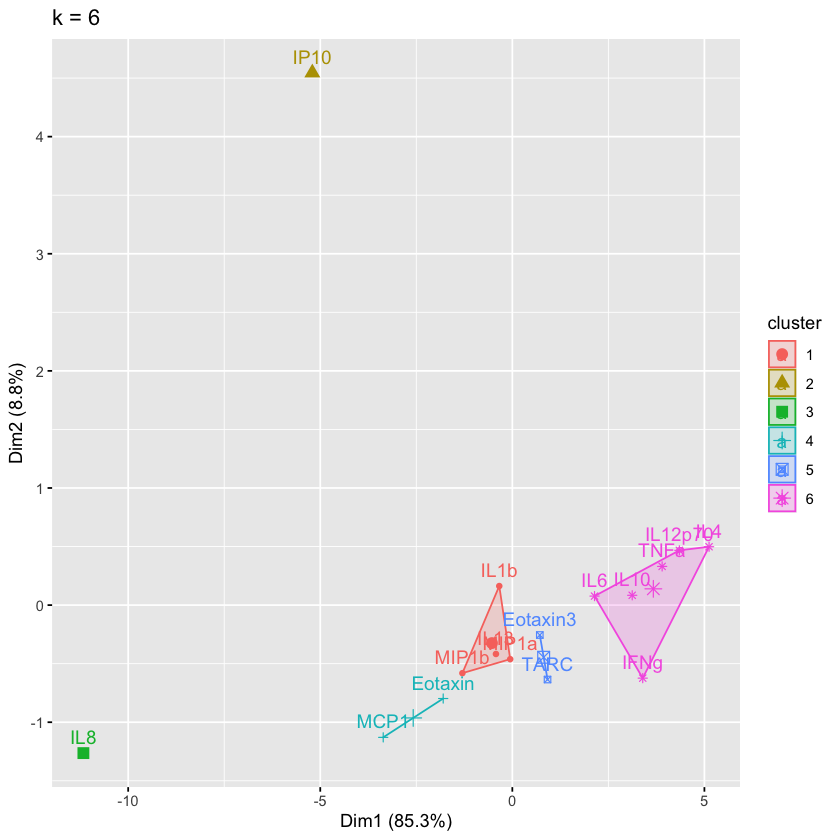

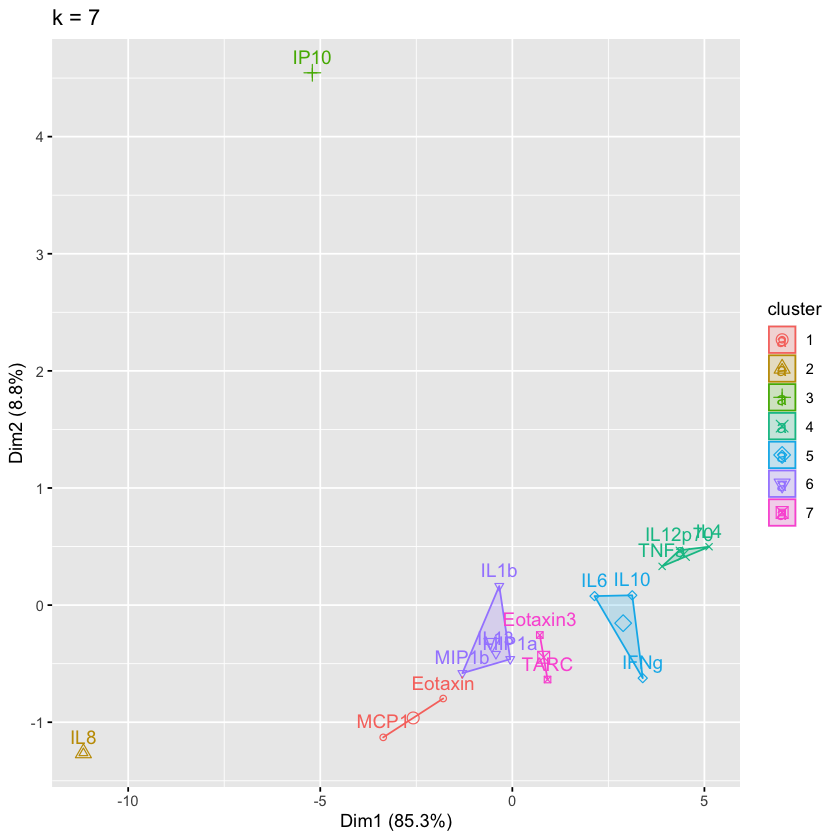

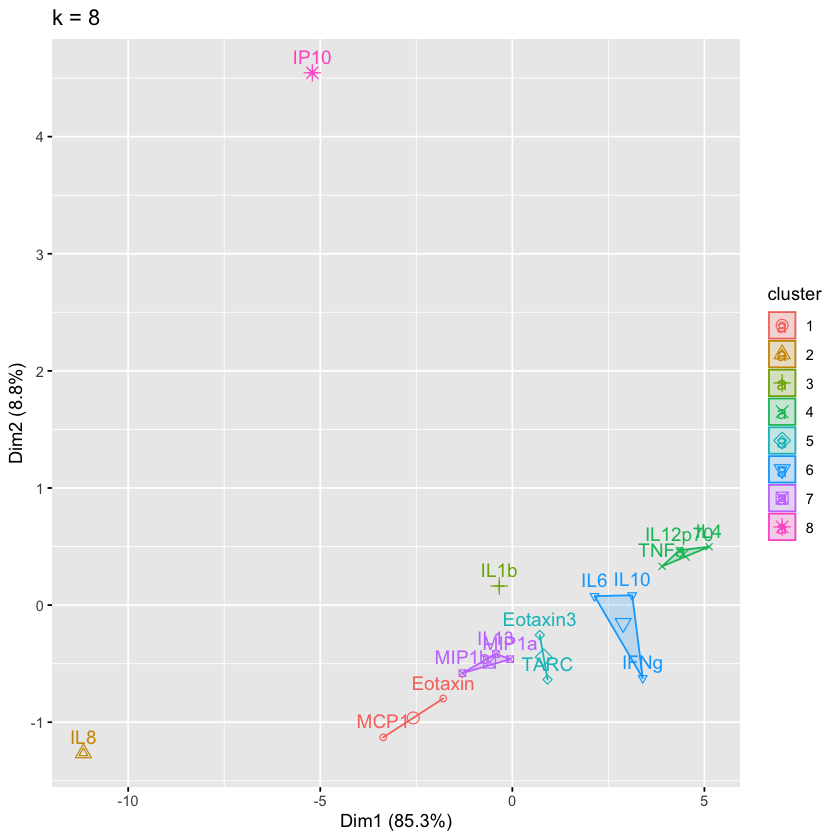

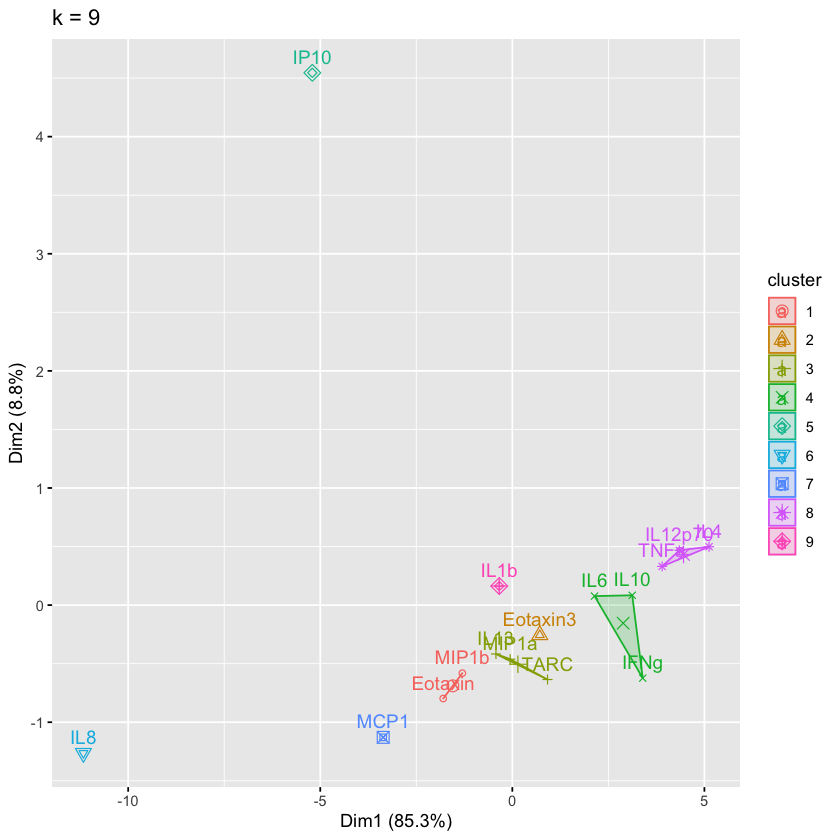

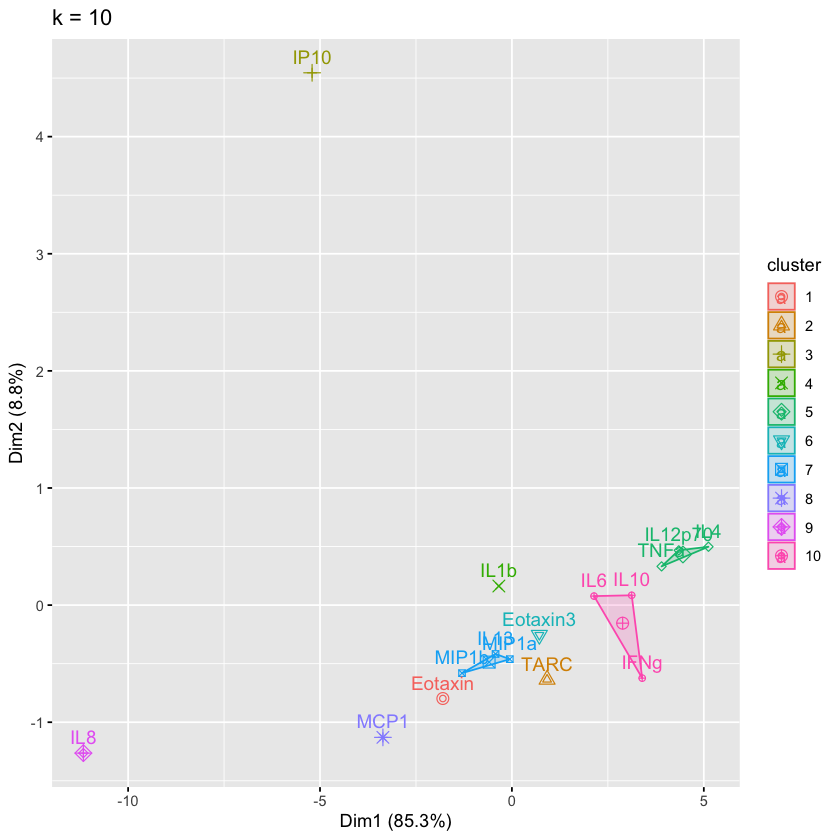

In [6]:
# Testing different numbers of clusters (k)
cluster_plots = list()
for (i in 2:10){
    cytokines_Cluster_k <- kmeans(tcytokines, centers = i, nstart = 25)
    cluster_plots[[i]] <- fviz_cluster(cytokines_Cluster_k, data = tcytokines) + ggtitle(paste0("k = ",i))
    print(cluster_plots[[i]])
}

In [7]:
#exporting clusters
# Exporting final cytokine cluster assignments (k=3)
tcytokines_Cluster_k3 <- kmeans(tcytokines, centers = 3, nstart=25)
cytokines_cluster_k3 <- as.data.frame(tcytokines_Cluster_k3$cluster) 
colnames(cytokines_cluster_k3)[1] <- "Cluster"

#write.csv(cytokines_cluster_k3, paste0(Output,"/", cur_date, "cytokines_cluster_assignments.csv"), row.names=TRUE)

Since three appears to be the optimal number that will be visualized. 

# Baseline Cluster Visualization of Both Datasets (Figure 6)

Using fviz_cluster is a bit clunky, so the results from kmeans needs to parsed in a way that ggplot will understand. Also combining dfs from both datasets from the NELF compartment to visualize together.

In [8]:
#parsing prcomp for visualization
trythis<-stats::prcomp(tcytokines, scale = TRUE, center = TRUE)
all_scores_new_df<-as.data.frame(scores(trythis)) %>%
    select(PC1, PC2) %>%
    rownames_to_column(var = "Protein")
all_scores_new_df$Cluster <- tcytokines_Cluster_k3$cluster
all_scores_new_df$Dataset = rep("Validation NELF Dataset", times = length(all_scores_new_df$PC1))

grp.1.cytokines <- all_scores_new_df[all_scores_new_df$Cluster == 1, ][chull(all_scores_new_df %>% filter(Cluster ==1) %>% select(PC1, PC2) ), ]  # hull values for cluster 1
grp.2.cytokines <- all_scores_new_df[all_scores_new_df$Cluster == 2, ][chull(all_scores_new_df %>% filter(Cluster ==2) %>% select(PC1, PC2) ), ]  # hull values for cluster 2
grp.3.cytokines <- all_scores_new_df[all_scores_new_df$Cluster == 3, ][chull(all_scores_new_df %>% filter(Cluster ==3) %>% select(PC1, PC2) ), ]  # hull values for cluster 3
all_hulls_new_df <- rbind(grp.1.cytokines,grp.2.cytokines,grp.3.cytokines) 

In [9]:
#reading in scores and hulls dfs from original dataset
og_scores_df = read_csv("041621_NELF_scores.csv")%>%
    select(PC1, PC2, Cluster, Protein)
og_scores_df$Dataset = rep("Original NELF Dataset", times = length(og_scores_df$PC1))
og_hulls_df = read_csv("041621_NELF_hulls.csv")%>%
    select(PC1, PC2, Cluster, Protein)
og_hulls_df$Dataset = rep("Original NELF Dataset", times = length(og_hulls_df$PC1))
                          
#combining and viewing below
all_scores_df = rbind(og_scores_df, all_scores_new_df)
all_scores_df$Dataset = factor(all_scores_df$Dataset, levels = c("Original NELF Dataset", "Validation NELF Dataset"))
all_hulls_df = rbind(og_hulls_df, all_hulls_new_df)
all_hulls_df$Dataset = factor(all_hulls_df$Dataset, levels = c("Original NELF Dataset", "Validation NELF Dataset"))
head(all_scores_df)
head(all_hulls_df)


── Column specification ────────────────────────────────────────────────────────
cols(
  PC1 = col_double(),
  PC2 = col_double(),
  PC3 = col_double(),
  PC4 = col_double(),
  PC5 = col_double(),
  PC6 = col_double(),
  PC7 = col_double(),
  PC8 = col_double(),
  PC9 = col_double(),
  PC10 = col_double(),
  PC11 = col_double(),
  PC12 = col_double(),
  PC13 = col_double(),
  PC14 = col_double(),
  Cluster = col_double(),
  Protein = col_character(),
  Compartment = col_character()
)



── Column specification ────────────────────────────────────────────────────────
cols(
  PC1 = col_double(),
  PC2 = col_double(),
  PC3 = col_double(),
  PC4 = col_double(),
  PC5 = col_double(),
  PC6 = col_double(),
  PC7 = col_double(),
  PC8 = col_double(),
  PC9 = col_double(),
  PC10 = col_double(),
  PC11 = col_double(),
  PC12 = col_double(),
  PC13 = col_double(),
  PC14 = col_double(),
  Cluster = col_double(),
  Protein = col_character(),
  Compartment = col_character()
)




PC1,PC2,Cluster,Protein,Dataset
<dbl>,<dbl>,<dbl>,<chr>,<fct>
-1.4837936,-0.37325290,3,Eotaxin,Original NELF Dataset
0.7505718,-1.04251406,3,Eotaxin3,Original NELF Dataset
-7.0500961,-0.49034208,2,Fractalkine,Original NELF Dataset
4.6869896,0.42263944,1,I309,Original NELF Dataset
2.4935464,-0.21910385,1,IFNg,Original NELF Dataset
3.4361668,-0.04689914,1,IL10,Original NELF Dataset


PC1,PC2,Cluster,Protein,Dataset
<dbl>,<dbl>,<dbl>,<chr>,<fct>
3.436167,-0.04689914,1,IL10,Original NELF Dataset
2.493546,-0.21910385,1,IFNg,Original NELF Dataset
2.395497,-0.05728780,1,TNFa,Original NELF Dataset
2.509288,0.53888370,1,IL17D,Original NELF Dataset
4.686990,0.42263944,1,I309,Original NELF Dataset
4.742547,0.30157171,1,IL4,Original NELF Dataset


Warning message:
“ggrepel: 1 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


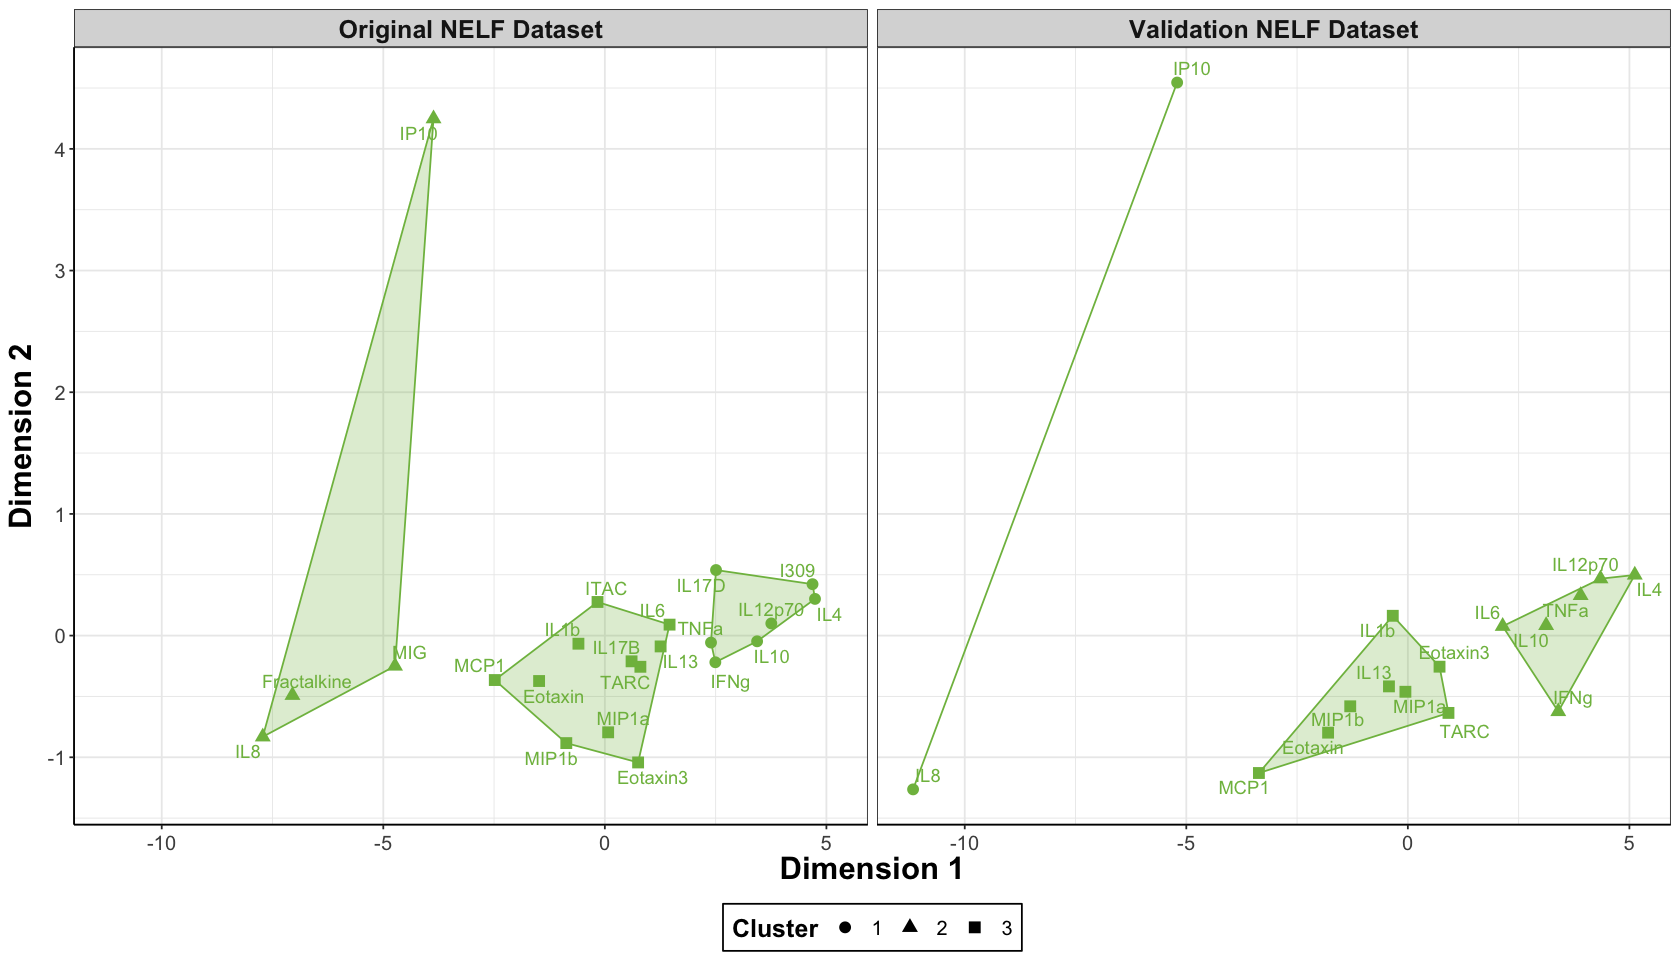

In [10]:
options(repr.plot.width=14, repr.plot.height=8) #changing size
Figure6 = ggplot() + 
  geom_point(data = all_scores_df, aes(x = PC1, y = PC2, color = '#7fbb4d', shape = as.factor(Cluster)), size = 3) + 
  geom_text_repel(data = all_scores_df, aes(x = PC1, y = PC2, color = '#7fbb4d', label = Protein), 
                  show.legend = FALSE) + 
  geom_polygon(data = all_hulls_df, aes(x = PC1, y = PC2, group = as.factor(Cluster), color = '#7fbb4d', 
                                        fill = '#7fbb4d'), alpha = 0.25, show.legend = FALSE) + 

  facet_wrap(~Dataset) + 

  theme_bw() + 
  theme(axis.text.x = element_text(vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour="black"), #making x and y axes black
        axis.text = element_text(size = 12), #changing size of x axis labels
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        legend.title = element_text(face = 'bold', size = 15), #changes legend title
        legend.text = element_text(size = 12), #changes legend text
        legend.position = 'bottom',
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
        strip.text.x = element_text(size = 15, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 15, face = "bold")) + #changes size of facet y axis 
  xlab('Dimension 1') + ylab('Dimension 2') + #changing axis labels 
  scale_color_manual(name = 'Cluster',
                      values = c('#7fbb4d', '#7fbb4d', '#7fbb4d')) +
  scale_fill_manual(name = 'Cluster',
                      values = c('#7fbb4d', '#7fbb4d', '#7fbb4d')) +

  guides(color = FALSE, shape = guide_legend(title = "Cluster")) #removing legend for color and changing title

Figure6

In [11]:
ggsave(Figure6, 
       filename = 'Figure6.pdf',
       path = Output,
       width = 14, height = 8)

Looking at loadings (weights) to determine which cytokines are driving the clusters.

In [43]:
pca_cytokines = prcomp(cytokines, scale = TRUE, center = TRUE)
new_pca_weights = pca_cytokines$rotation 
new_pca_weights
#get_pca_var(pca_cytokines)$contrib #contrib to PC..but idk how this is different from rotation??

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16
Eotaxin,0.20053871,-0.31625018,-0.27668116,-0.09530918,0.3877521865,-0.230516186,0.46589534,-0.35332993,0.19371804,-0.31931867,0.0002150916,-0.04543552,0.02668497,0.2584946954,-0.112777543,0.08329388
Eotaxin3,0.23682697,-0.18546050,-0.33075264,-0.21563575,0.3146909689,0.279675980,-0.41152990,0.05966426,-0.07005076,0.01263451,-0.4647002817,-0.09919639,0.24862468,-0.2707698574,-0.177564755,-0.07708925
IFNg,0.22740417,-0.17362135,0.13052269,0.50688980,0.2059675747,0.553130666,0.16049789,0.08736619,-0.27994091,-0.04838169,0.2274211940,-0.16225834,0.20765533,0.1155960148,0.202841033,0.07757189
IL10,0.32365968,0.08754443,-0.07733138,0.14338513,0.1075300364,-0.131421845,-0.08860178,-0.11321167,0.24050344,0.06334173,0.4789560610,0.11782318,0.10869934,-0.3448137765,-0.004511088,-0.61292059
IL12p70,0.30125123,0.20306134,0.08850015,0.08486708,0.0290918538,-0.200284265,0.39319567,0.07251530,-0.25026523,-0.08727167,-0.2680206679,0.33158338,0.01446686,-0.5638989488,0.155497920,0.24032292
IL13,0.29369519,-0.10012001,0.10482618,-0.17131579,-0.1536360122,-0.417685627,-0.22891258,0.37640996,-0.15354738,-0.22559310,0.2737063052,-0.08044577,0.48615540,0.1603032622,-0.052312579,0.22493161
IL1b,0.26603525,0.25324798,-0.07595949,0.06086725,-0.4647755281,0.154976945,0.18677967,-0.03252048,0.14217793,-0.11140544,-0.4058349351,0.13563777,0.31138968,0.3824799299,0.058210133,-0.34244632
IL4,0.29096242,0.20068934,-0.21503067,0.14830180,-0.0176743756,0.146546113,0.10791376,0.42639687,0.19542265,0.10645588,0.1150100121,0.07795170,-0.32500309,0.0922488784,-0.606239496,0.20272000
IL6,0.29316654,0.16154799,0.10259136,0.12469970,0.0008097634,-0.207661764,-0.21175183,-0.47354048,-0.58201888,0.16881616,-0.0500788158,-0.06447647,-0.19636741,0.2211256353,-0.290483438,-0.06268831
IL8,0.32287338,0.10123794,-0.05849668,-0.02846464,-0.1759117845,-0.096539941,0.02317546,0.05447006,0.13691976,-0.05994049,-0.0866417042,-0.76559821,-0.33093868,-0.1364087764,0.305411161,0.01056088


,Dim.1,Dim.2,Dim.3,Dim.4,Dim.5,Dim.6,Dim.7,Dim.8,Dim.9,Dim.10,Dim.11,Dim.12,Dim.13,Dim.14,Dim.15,Dim.16
Eotaxin,4.0215772,10.0014175,7.6552467,0.90838398,1.503518e+01,5.313771180,21.70584724,12.48420416,3.75266786,10.19644111,4.626440e-06,0.2064386,0.07120879,6.681951e+00,1.271877419,0.69378704
Eotaxin3,5.6087013,3.4395598,10.9397312,4.64987769,9.903041e+00,7.821865378,16.93568598,0.35598241,0.49071095,0.01596308,2.159464e+01,0.9839923,6.18142315,7.331632e+00,3.152924208,0.59427524
IFNg,5.1712656,3.0144373,1.7036174,25.69372670,4.242264e+00,30.595353416,2.57595730,0.76328517,7.83669132,0.23407884,5.172040e+00,2.6327770,4.31207372,1.336244e+00,4.114448477,0.60173985
IL10,10.4755589,0.7664028,0.5980143,2.05592943,1.156271e+00,1.727170147,0.78502748,1.28168830,5.78419039,0.40121743,2.293989e+01,1.3882303,1.18155467,1.188965e+01,0.002034992,37.56716519
IL12p70,9.0752303,4.1233906,0.7832276,0.72024218,8.463360e-02,4.011378674,15.46028345,0.52584688,6.26326851,0.76163439,7.183508e+00,10.9947535,0.02092901,3.179820e+01,2.417960322,5.77551058
IL13,8.6256866,1.0024016,1.0988528,2.93490987,2.360402e+00,17.446128263,5.24009715,14.16844601,2.35767982,5.08922467,7.491514e+00,0.6471521,23.63470740,2.569714e+00,0.273660590,5.05942296
IL1b,7.0774752,6.4134541,0.5769845,0.37048219,2.160163e+01,2.401785362,3.48866464,0.10575818,2.02145646,1.24111718,1.647020e+01,1.8397604,9.69635353,1.462909e+01,0.338841955,11.72694803
IL4,8.4659130,4.0276211,4.6238188,2.19934236,3.123836e-02,2.147576331,1.16453805,18.18142938,3.81900133,1.13328553,1.322730e+00,0.6076468,10.56270063,8.509856e-01,36.752632687,4.10953982
IL6,8.5946618,2.6097752,1.0524987,1.55500159,6.557167e-05,4.312340826,4.48388365,22.42405889,33.87459787,2.84988946,2.507888e-01,0.4157216,3.85601608,4.889655e+00,8.438062794,0.39298247
IL8,10.4247221,1.0249121,0.3421862,0.08102359,3.094496e+00,0.931996021,0.05371021,0.29669875,1.87470198,0.35928620,7.506785e-01,58.6140614,10.95204101,1.860735e+00,9.327597728,0.01115322


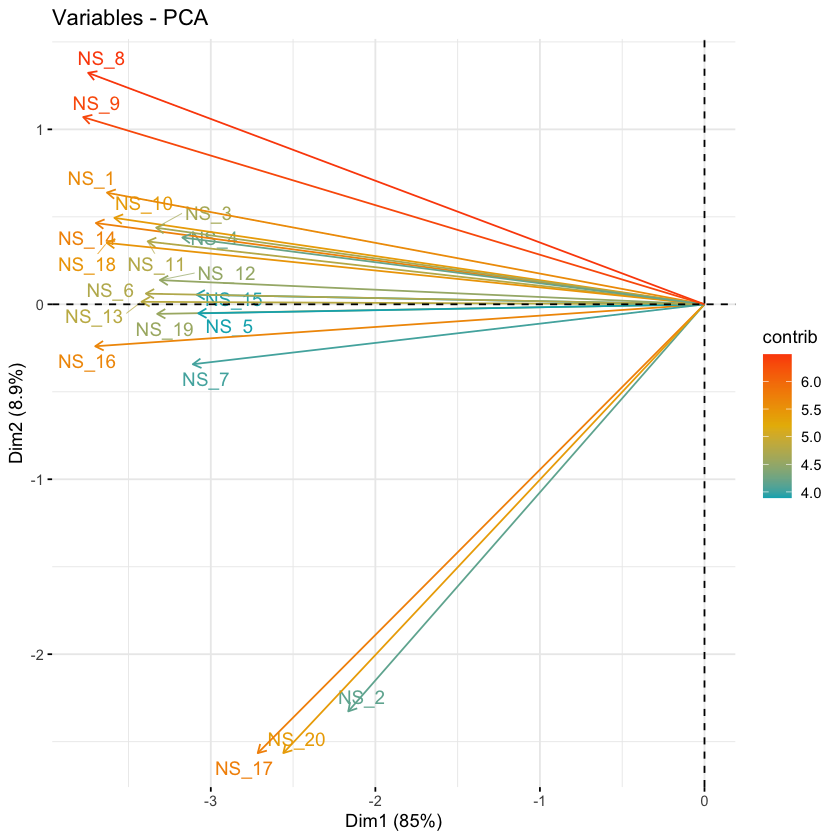

In [23]:
tcytokines = data.frame(t(cytokines)) 
tcytokines_scaled = data.frame(t(cytokines_scaled))
pca_tcytokines = tcytokines %>% prcomp()

#shows individuals that are driving clusters
fviz_pca_var(pca_tcytokines,
             col.var = "contrib", # Color by contributions to the PC
             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
             repel = TRUE     # Avoid text overlapping
             )

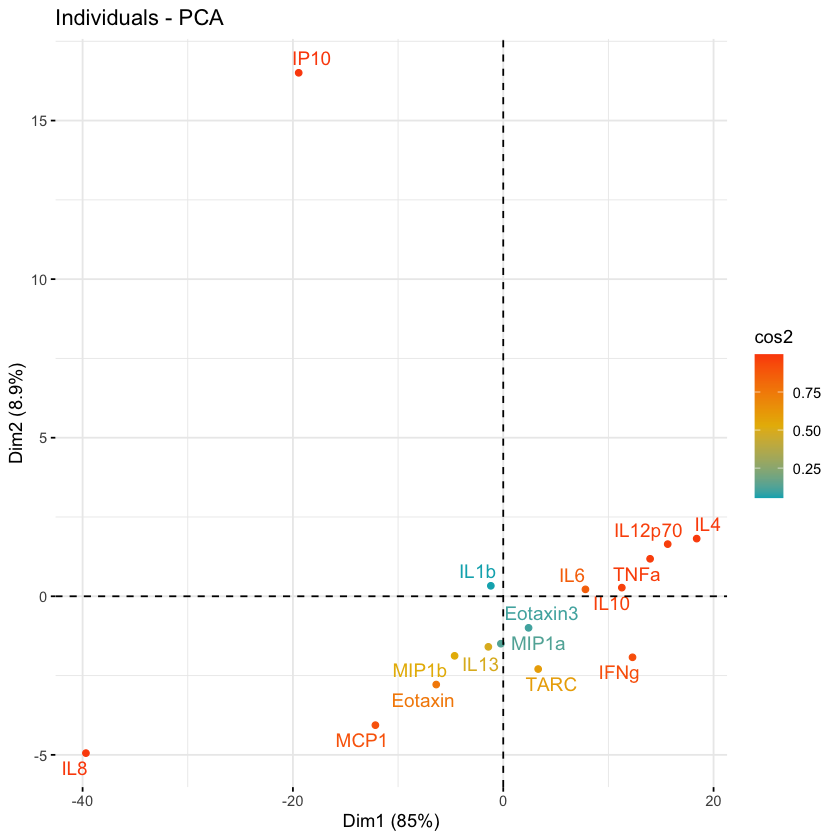

In [21]:
#shows cytokines that contribute more to each cluster??
fviz_pca_ind(pca_tcytokines,
             col.ind = "cos2", # Color by the quality of representation
             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
             repel = TRUE     # Avoid text overlapping
             )

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16
NS_1,-0.2447833,0.132775518,0.276973945,-0.516517088,-0.067972537,-0.408018173,0.03482717,0.27483914,0.07883114,-0.236466355,0.068760290,-0.138626477,0.05921745,0.308827970,-0.12403760,0.03670076
NS_10,-0.2417496,0.102778143,-0.089962984,-0.244661657,0.206771475,0.277541910,-0.01174815,0.11181554,-0.20848225,0.042412271,0.048936224,-0.078277808,-0.20494868,-0.373563434,0.34936812,0.26530768
NS_11,-0.2281130,0.074761755,-0.369726156,0.087774866,-0.500426490,-0.125091827,-0.11146532,-0.17367039,0.26672049,-0.376091637,-0.125226566,0.114017074,0.08112308,-0.270137566,0.21045000,-0.04994298
NS_12,-0.2231162,0.028805081,-0.246429212,0.234061778,0.102204937,-0.153592353,-0.19796035,0.22001396,0.27153891,-0.008458314,0.092977934,-0.240710125,-0.22131783,0.159203848,0.29063924,-0.05854143
NS_13,-0.2306376,0.003044322,0.023396487,-0.030791876,-0.002567099,0.045936436,0.03067444,0.14508776,0.27958637,0.190149293,-0.311312887,0.431772648,0.01028519,0.282326686,0.16623537,-0.33151407
NS_14,-0.2493255,0.096611372,0.245358059,-0.258329982,-0.039868801,0.182119571,0.10389467,-0.07119640,-0.12815349,-0.027796496,-0.078841402,0.237491599,0.26551619,-0.277507405,-0.02808543,-0.36380953
NS_15,-0.2080641,0.011487352,-0.080420640,0.088211537,0.058029845,0.339461468,0.28105067,0.05633783,0.43066711,0.282471345,-0.295249835,-0.414257883,0.22787493,-0.009731785,-0.30272185,0.07816344
NS_16,-0.2495942,-0.049858195,-0.003524022,0.164725709,-0.127239182,-0.103569049,-0.17269327,0.08781862,-0.10655315,-0.209942056,0.055871327,-0.170565475,0.21104466,0.017392099,-0.36651254,0.23327886
NS_17,-0.1830157,-0.533323650,0.041906742,0.006098654,0.233426055,-0.059051597,-0.15391522,0.01293907,0.11079997,-0.074546856,-0.192050930,0.327200742,-0.45870758,-0.061860354,-0.31700107,0.11079575
NS_18,-0.2448990,0.073023203,-0.307732429,0.009313520,0.558493948,-0.379057680,0.18478358,-0.38138077,-0.21406992,-0.100601781,-0.259842923,0.003498986,0.23895978,0.021727721,0.01563578,0.03488748


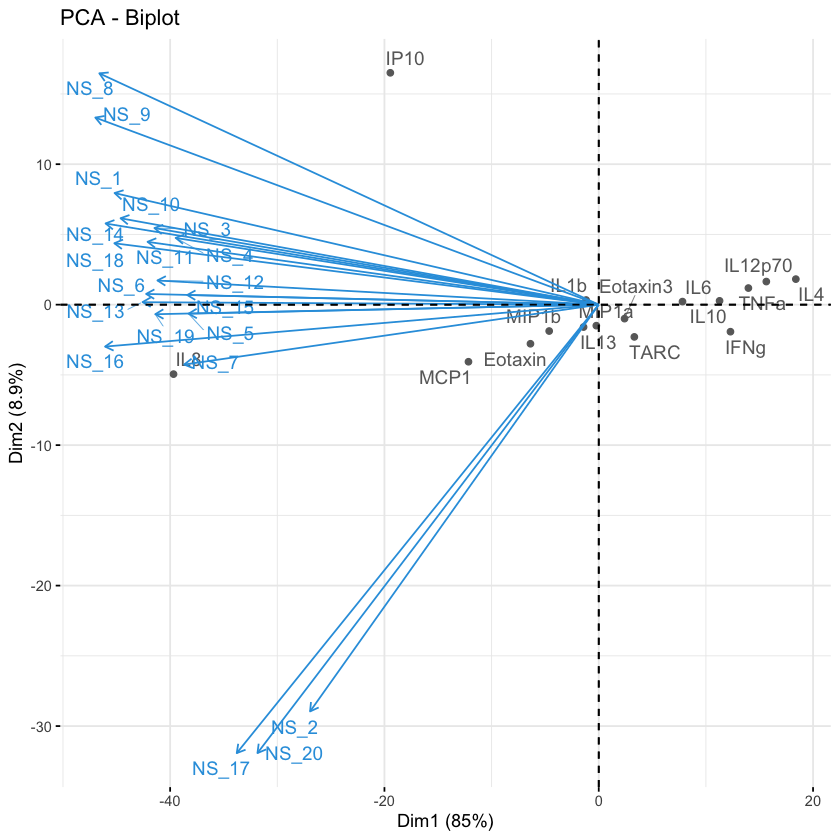

In [25]:
fviz_pca_biplot(pca_tcytokines, repel = TRUE,
                col.var = "#2E9FDF", # Variables color
                col.ind = "#696969")  # Individuals color